# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.076658,True,7.010103
1,-0.818287,True,4.144617
2,-1.357600,False,-1.411497
3,-0.551434,False,-2.106658
4,0.375440,True,5.472941
...,...,...,...
995,-0.248874,False,0.537685
996,-1.450443,True,3.566526
997,0.986650,True,4.553716
998,-1.470916,True,3.384282


<Axes: xlabel='v0'>

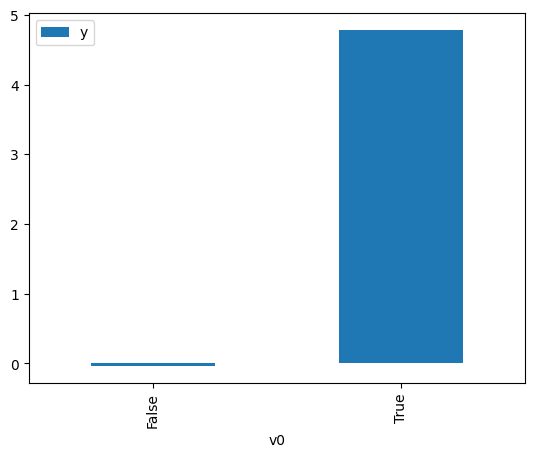

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

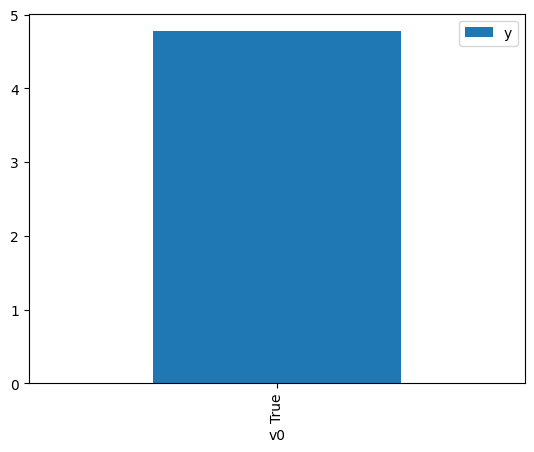

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.023610,False,-1.910086,0.642354,1.556774
1,-1.403685,False,-1.900697,0.685734,1.458291
2,0.400229,False,0.036046,0.464156,2.154449
3,-0.480230,False,0.553328,0.576227,1.735427
4,-0.666446,False,-1.625224,0.599330,1.668530
...,...,...,...,...,...
995,-0.136659,False,0.117727,0.532789,1.876916
996,-0.069062,False,-1.138095,0.524162,1.907806
997,0.081842,False,2.040245,0.504860,1.980749
998,0.046378,False,0.123123,0.509399,1.963097


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.538058,True,6.404222,0.553349,1.807177
1,-0.636204,True,3.867249,0.404395,2.472830
2,-1.356975,True,3.226207,0.319444,3.130441
3,1.200055,True,5.435784,0.634890,1.575076
4,-1.148039,True,4.261587,0.343142,2.914243
...,...,...,...,...,...
995,-0.025496,True,3.985763,0.481406,2.077250
996,-1.137647,True,4.087798,0.344343,2.904082
997,-1.775961,True,2.899828,0.274699,3.640353
998,-0.575907,True,3.660153,0.411854,2.428043


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              6611.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:19:57   Log-Likelihood:                         -1416.4
No. Observations:                1000   AIC:                                      2837.
Df Residuals:                     998   BIC:                                      2847.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0087      0.031     32.214      0.000       0.947       1.070
x2             4.9383      0.046    106.859      0.000       4.848       5.029
==============================================================================
Omnibus:                        3.335   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                3.748
Skew:                           0.010   Prob(JB):                        0.153
Kurtosis:                       3.299   Cond. No.                         1.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""